# 08 - Carbon Sequestration & Resilience Analysis

This notebook demonstrates:
1. **Carbon sequestration metrics** - Measuring climate impact of tree growth strategies
2. **Carbon-optimized policy training** - Learning to maximize permanent carbon storage
3. **Resilience analysis** - Identifying tipping points and survival boundaries
4. **Carbon vs Seed tradeoffs** - Comparing different optimization objectives

**Climate relevance**: Trees sequester atmospheric CO2, but not all storage is equal.
Trunk wood persists for decades; leaves decompose within a year. Our carbon score
weights permanence to reflect real climate impact.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from sim import (
    ClimateConfig, SimConfig, NeuralPolicy, run_season, stress,
    compute_carbon_content, compute_carbon_score, compute_carbon_summary,
    parameter_sweep_2d, sensitivity_sweep, find_tipping_points,
    compute_resilience_boundary, plot_fitness_landscape, plot_sensitivity_curve,
)
from sim.config import TreeState
from sim.dynamics import step, compute_seeds
from sim.policies import (
    baseline_policy, make_policy_features, softmax_allocation,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

jax.config.update('jax_enable_x64', True)
print(f"JAX version: {jax.__version__}")

JAX version: 0.8.1


## 1. Carbon Metrics Overview

Carbon content varies by tissue type:
- **Trunk (wood)**: ~50% carbon, permanence=1.0 (decades to centuries)
- **Roots**: ~45% carbon, permanence=0.7 (years)
- **Shoots**: ~45% carbon, permanence=0.3 (seasonal)
- **Leaves**: ~45% carbon, permanence=0.1 (decompose within a year)
- **Flowers**: ~40% carbon, permanence=0.05 (ephemeral)

In [2]:
# Setup
config = SimConfig(num_days=100)
mild_climate = ClimateConfig.mild()

# Run baseline policy and examine carbon metrics
trajectory = run_season(config, mild_climate, baseline_policy)

# Get carbon summary
carbon_summary = trajectory.get_carbon_summary(config)

print("Carbon Metrics for Baseline Policy (Mild Climate)")
print("=" * 50)
for key, value in carbon_summary.items():
    print(f"{key:25s}: {value:.4f}")
print("=" * 50)
print(f"Seeds produced: {float(trajectory.seeds):.4f}")

Carbon Metrics for Baseline Policy (Mild Climate)
FinalTotalCarbon         : 1.4850
FinalPermanentCarbon     : 0.8834
FinalSeasonalCarbon      : 0.6016
FinalCarbonScore         : 0.8825
PeakTotalCarbon          : 1.4850
PeakPermanentCarbon      : 0.8834
MeanCarbonScore          : 0.3895
CarbonIntegral           : 39.3442
TrunkCarbonFraction      : 0.3905
Seeds produced: 0.5687


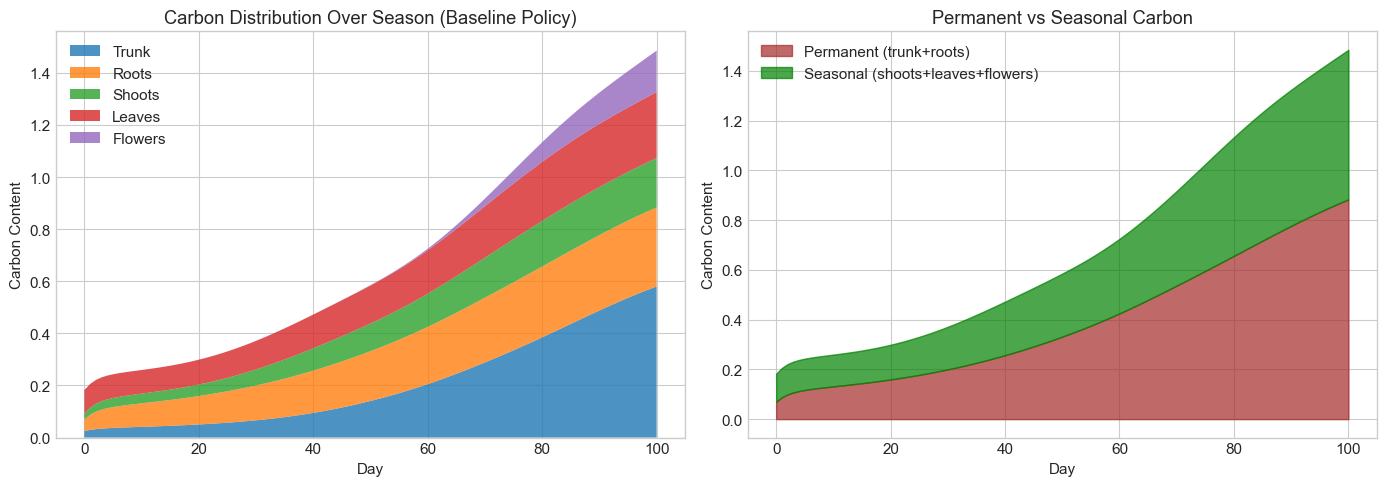

In [3]:
# Visualize carbon distribution over time
states = trajectory.states
days = np.arange(len(states))

# Compute carbon content at each timestep
carbon_history = []
for state in states:
    content = compute_carbon_content(state, config)
    carbon_history.append({
        'trunk': float(content['trunk_carbon']),
        'roots': float(content['roots_carbon']),
        'shoots': float(content['shoots_carbon']),
        'leaves': float(content['leaves_carbon']),
        'flowers': float(content['flowers_carbon']),
        'total': float(content['total_carbon']),
        'permanent': float(content['permanent_carbon']),
    })

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stacked carbon by compartment
ax1.stackplot(days,
    [c['trunk'] for c in carbon_history],
    [c['roots'] for c in carbon_history],
    [c['shoots'] for c in carbon_history],
    [c['leaves'] for c in carbon_history],
    [c['flowers'] for c in carbon_history],
    labels=['Trunk', 'Roots', 'Shoots', 'Leaves', 'Flowers'],
    alpha=0.8)
ax1.set_xlabel('Day')
ax1.set_ylabel('Carbon Content')
ax1.set_title('Carbon Distribution Over Season (Baseline Policy)')
ax1.legend(loc='upper left')

# Permanent vs seasonal carbon
ax2.fill_between(days, 0, [c['permanent'] for c in carbon_history],
                 label='Permanent (trunk+roots)', alpha=0.7, color='brown')
ax2.fill_between(days, [c['permanent'] for c in carbon_history],
                 [c['total'] for c in carbon_history],
                 label='Seasonal (shoots+leaves+flowers)', alpha=0.7, color='green')
ax2.set_xlabel('Day')
ax2.set_ylabel('Carbon Content')
ax2.set_title('Permanent vs Seasonal Carbon')
ax2.legend()

plt.tight_layout()
plt.show()

## 2. Compare Carbon Metrics Across Policies

Different allocation strategies produce different carbon profiles.

In [4]:
from sim.policies import growth_focused_policy, defensive_policy, reproduction_policy

policies = {
    'Baseline': baseline_policy,
    'Growth-focused': growth_focused_policy,
    'Defensive': defensive_policy,
    'Reproduction': reproduction_policy,
}

results = {}
for name, policy in policies.items():
    traj = run_season(config, mild_climate, policy)
    carbon_sum = traj.get_carbon_summary(config)
    results[name] = {
        'seeds': float(traj.seeds),
        'carbon_score': carbon_sum['FinalCarbonScore'],
        'trunk_carbon': carbon_sum['TrunkCarbonFraction'],
        'total_carbon': carbon_sum['FinalTotalCarbon'],
    }

# Display comparison
print("Policy Comparison (Mild Climate)")
print("=" * 70)
print(f"{'Policy':<18} {'Seeds':>10} {'Carbon Score':>14} {'Total Carbon':>14} {'Trunk %':>10}")
print("-" * 70)
for name, r in results.items():
    print(f"{name:<18} {r['seeds']:>10.3f} {r['carbon_score']:>14.4f} {r['total_carbon']:>14.4f} {r['trunk_carbon']*100:>9.1f}%")
print("=" * 70)

Policy Comparison (Mild Climate)
Policy                  Seeds   Carbon Score   Total Carbon    Trunk %
----------------------------------------------------------------------
Baseline                0.569         0.8825         1.4850      39.1%
Growth-focused          0.034         0.5408         1.1683       6.8%
Defensive               0.024         0.8198         1.0438      61.3%
Reproduction            0.349         0.3755         0.8590      22.6%


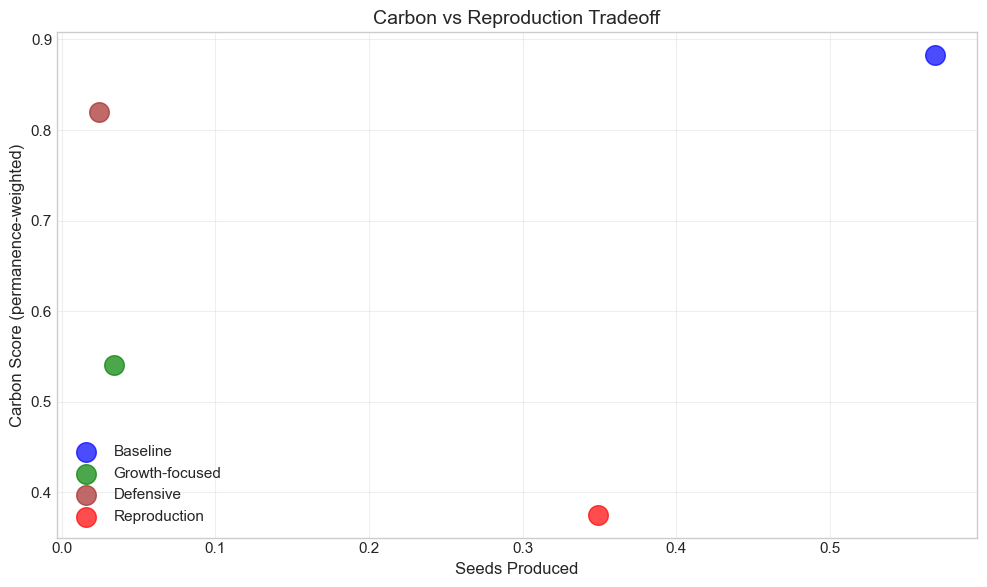

Saved: carbon_seed_tradeoff_handcoded.png


In [5]:
# Visualize carbon vs seeds tradeoff
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'green', 'brown', 'red']
for (name, r), color in zip(results.items(), colors):
    ax.scatter(r['seeds'], r['carbon_score'], s=200, c=color, label=name, alpha=0.7)

ax.set_xlabel('Seeds Produced', fontsize=12)
ax.set_ylabel('Carbon Score (permanence-weighted)', fontsize=12)
ax.set_title('Carbon vs Reproduction Tradeoff', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('carbon_seed_tradeoff_handcoded.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: carbon_seed_tradeoff_handcoded.png")

## 3. Train Carbon-Optimized Policy

Now let's train a neural policy to maximize carbon sequestration instead of seeds.

In [6]:
# Precompute environment
def precompute_environment(climate, num_days):
    light, moisture, wind = stress.compute_environment_batch(climate, num_days)
    return light, moisture, wind

mild_env = precompute_environment(mild_climate, config.num_days)

# JIT-compatible rollout that tracks carbon
def rollout_with_carbon(
    policy: NeuralPolicy,
    config: SimConfig,
    light_arr, moisture_arr, wind_arr,
):
    """Rollout that returns both seeds and carbon integral."""
    num_days = config.num_days
    
    def body_fn(carry, day):
        state, carbon_integral = carry
        light = light_arr[day]
        moisture = moisture_arr[day]
        wind = wind_arr[day]
        
        features = make_policy_features(state, day, num_days, light, moisture, wind)
        logits = policy(features)
        allocation = softmax_allocation(logits)
        
        state = step(state, allocation, light, moisture, wind, config, day)
        
        # Compute carbon score for this state
        carbon = compute_carbon_score(state, config)
        carbon_integral = carbon_integral + carbon
        
        return (state, carbon_integral), None
    
    initial_state = TreeState.initial(energy=config.seed_energy)
    (final_state, carbon_integral), _ = jax.lax.scan(
        body_fn, (initial_state, jnp.array(0.0)), jnp.arange(num_days)
    )
    
    seeds = compute_seeds(final_state, config)
    
    return final_state, seeds, carbon_integral

# Test
key = jr.PRNGKey(42)
test_policy = NeuralPolicy(key, hidden_size=32, num_hidden=2)
_, seeds, carbon = rollout_with_carbon(test_policy, config, *mild_env)
print(f"Initial policy - Seeds: {float(seeds):.4f}, Carbon integral: {float(carbon):.4f}")

Initial policy - Seeds: 0.3823, Carbon integral: 38.4714


In [7]:
# Loss function for carbon optimization
def carbon_loss_fn(
    policy: NeuralPolicy,
    config: SimConfig,
    light_arr, moisture_arr, wind_arr,
    l2_weight: float = 0.0001,
):
    """Loss = negative carbon integral (we want to maximize carbon)."""
    _, _, carbon_integral = rollout_with_carbon(
        policy, config, light_arr, moisture_arr, wind_arr
    )
    
    # L2 regularization
    params = eqx.filter(policy, eqx.is_array)
    l2 = sum(jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params))
    
    return -carbon_integral + l2_weight * l2


@eqx.filter_jit
def carbon_train_step(
    policy: NeuralPolicy,
    opt_state,
    optimizer,
    config: SimConfig,
    light_arr, moisture_arr, wind_arr,
):
    loss, grads = eqx.filter_value_and_grad(carbon_loss_fn)(
        policy, config, light_arr, moisture_arr, wind_arr
    )
    updates, opt_state = optimizer.update(grads, opt_state, policy)
    policy = eqx.apply_updates(policy, updates)
    return policy, opt_state, loss


def train_carbon_policy(
    policy: NeuralPolicy,
    config: SimConfig,
    light_arr, moisture_arr, wind_arr,
    num_steps: int = 300,
    learning_rate: float = 0.01,
):
    """Train policy to maximize carbon sequestration."""
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=learning_rate * 0.1,
        peak_value=learning_rate,
        warmup_steps=20,
        decay_steps=num_steps,
        end_value=learning_rate * 0.01,
    )
    optimizer = optax.adam(schedule)
    opt_state = optimizer.init(eqx.filter(policy, eqx.is_array))
    
    loss_history = []
    carbon_history = []
    seed_history = []
    
    for i in tqdm(range(num_steps), desc="Training carbon policy"):
        policy, opt_state, loss = carbon_train_step(
            policy, opt_state, optimizer, config,
            light_arr, moisture_arr, wind_arr
        )
        
        _, seeds, carbon = rollout_with_carbon(policy, config, light_arr, moisture_arr, wind_arr)
        
        loss_history.append(float(loss))
        carbon_history.append(float(carbon))
        seed_history.append(float(seeds))
        
        if i % 50 == 0:
            print(f"Step {i:3d}: carbon={float(carbon):.2f}, seeds={float(seeds):.3f}")
    
    return policy, loss_history, carbon_history, seed_history

In [8]:
# Train carbon-optimized policy
print("="*60)
print("Training CARBON-OPTIMIZED policy")
print("="*60)

key = jr.PRNGKey(42)
policy_carbon = NeuralPolicy(key, hidden_size=32, num_hidden=2)

policy_carbon, loss_hist, carbon_hist, seed_hist = train_carbon_policy(
    policy_carbon, config, *mild_env,
    num_steps=300,
    learning_rate=0.01,
)

print(f"\nFinal: Carbon integral={carbon_hist[-1]:.2f}, Seeds={seed_hist[-1]:.3f}")

Training CARBON-OPTIMIZED policy


Training carbon policy:   0%|          | 0/300 [00:00<?, ?it/s]

Step   0: carbon=39.02, seeds=0.393


Step  50: carbon=58.83, seeds=0.002


Step 100: carbon=64.40, seeds=0.001


Step 150: carbon=65.83, seeds=0.000


Step 200: carbon=66.29, seeds=0.000


Step 250: carbon=66.41, seeds=0.000



Final: Carbon integral=66.44, Seeds=0.000


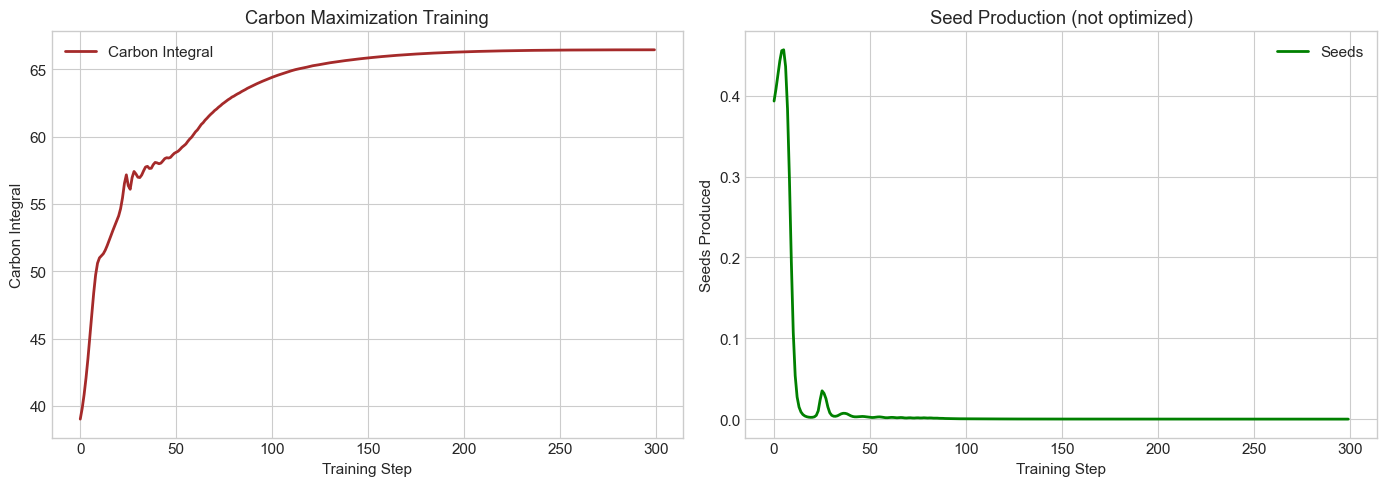

In [9]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(carbon_hist, linewidth=2, color='brown', label='Carbon Integral')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Carbon Integral')
ax1.set_title('Carbon Maximization Training')
ax1.legend()

ax2.plot(seed_hist, linewidth=2, color='green', label='Seeds')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Seeds Produced')
ax2.set_title('Seed Production (not optimized)')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Compare Carbon vs Seed Optimized Policies

Let's also train a seed-optimized policy for comparison.

In [10]:
# Train seed-optimized policy (from notebook 04)
from sim.dynamics import compute_seeds

def seed_loss_fn(policy, config, light_arr, moisture_arr, wind_arr, l2_weight=0.0001):
    _, seeds, _ = rollout_with_carbon(policy, config, light_arr, moisture_arr, wind_arr)
    params = eqx.filter(policy, eqx.is_array)
    l2 = sum(jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params))
    return -seeds + l2_weight * l2

@eqx.filter_jit
def seed_train_step(policy, opt_state, optimizer, config, light_arr, moisture_arr, wind_arr):
    loss, grads = eqx.filter_value_and_grad(seed_loss_fn)(policy, config, light_arr, moisture_arr, wind_arr)
    updates, opt_state = optimizer.update(grads, opt_state, policy)
    policy = eqx.apply_updates(policy, updates)
    return policy, opt_state, loss

print("="*60)
print("Training SEED-OPTIMIZED policy")
print("="*60)

key = jr.PRNGKey(42)
policy_seeds = NeuralPolicy(key, hidden_size=32, num_hidden=2)

schedule = optax.warmup_cosine_decay_schedule(0.001, 0.01, 20, 300, 0.0001)
optimizer = optax.adam(schedule)
opt_state = optimizer.init(eqx.filter(policy_seeds, eqx.is_array))

for i in tqdm(range(300), desc="Training seed policy"):
    policy_seeds, opt_state, _ = seed_train_step(
        policy_seeds, opt_state, optimizer, config, *mild_env
    )
    if i % 100 == 0:
        _, seeds, carbon = rollout_with_carbon(policy_seeds, config, *mild_env)
        print(f"Step {i}: seeds={float(seeds):.3f}, carbon={float(carbon):.2f}")

_, final_seeds, final_carbon = rollout_with_carbon(policy_seeds, config, *mild_env)
print(f"\nFinal: Seeds={float(final_seeds):.3f}, Carbon integral={float(final_carbon):.2f}")

Training SEED-OPTIMIZED policy


Training seed policy:   0%|          | 0/300 [00:00<?, ?it/s]

Step 0: seeds=0.403, carbon=38.82


Step 100: seeds=1.139, carbon=51.72


Step 200: seeds=1.554, carbon=46.11



Final: Seeds=1.631, Carbon integral=49.02


In [11]:
# Compare the two policies
_, carbon_seeds, carbon_carbon = rollout_with_carbon(policy_carbon, config, *mild_env)
_, seed_seeds, seed_carbon = rollout_with_carbon(policy_seeds, config, *mild_env)

print("\n" + "="*60)
print("POLICY COMPARISON: Carbon vs Seed Optimization")
print("="*60)
print(f"{'Metric':<25} {'Carbon Policy':>15} {'Seed Policy':>15}")
print("-"*60)
print(f"{'Seeds Produced':<25} {float(carbon_seeds):>15.3f} {float(seed_seeds):>15.3f}")
print(f"{'Carbon Integral':<25} {float(carbon_carbon):>15.2f} {float(seed_carbon):>15.2f}")
print("="*60)


POLICY COMPARISON: Carbon vs Seed Optimization
Metric                      Carbon Policy     Seed Policy
------------------------------------------------------------
Seeds Produced                      0.000           1.631
Carbon Integral                     66.44           49.02


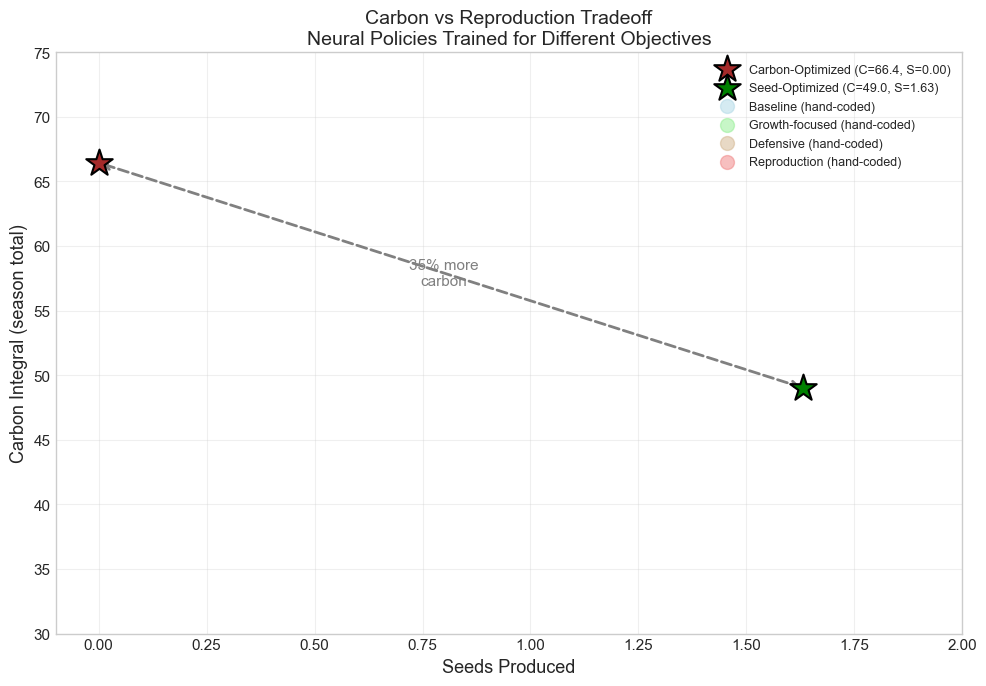

Saved: carbon_seed_tradeoff.png


In [12]:
# Create the key tradeoff visualization with trained policies
fig, ax = plt.subplots(figsize=(10, 7))

# Plot trained policies (the main result)
ax.scatter(float(carbon_seeds), float(carbon_carbon), s=400, c='brown', 
           label=f'Carbon-Optimized (C={float(carbon_carbon):.1f}, S={float(carbon_seeds):.2f})', 
           marker='*', edgecolors='black', linewidths=1.5, zorder=5)
ax.scatter(float(seed_seeds), float(seed_carbon), s=400, c='green', 
           label=f'Seed-Optimized (C={float(seed_carbon):.1f}, S={float(seed_seeds):.2f})', 
           marker='*', edgecolors='black', linewidths=1.5, zorder=5)

# Add hand-coded policies for reference (smaller, faded)
for (name, r), color in zip(results.items(), ['lightblue', 'lightgreen', 'tan', 'lightcoral']):
    ax.scatter(r['seeds'], r['carbon_score'], s=100, c=color, alpha=0.5, 
               label=f'{name} (hand-coded)')

# Arrow showing the tradeoff
ax.annotate('', xy=(float(seed_seeds), float(seed_carbon)), 
            xytext=(float(carbon_seeds), float(carbon_carbon)),
            arrowprops=dict(arrowstyle='<->', color='gray', lw=2, ls='--'))
ax.text(0.8, 57, '35% more\ncarbon', fontsize=11, ha='center', color='gray')

ax.set_xlabel('Seeds Produced', fontsize=13)
ax.set_ylabel('Carbon Integral (season total)', fontsize=13)
ax.set_title('Carbon vs Reproduction Tradeoff\nNeural Policies Trained for Different Objectives', fontsize=14)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.1, 2.0)
ax.set_ylim(30, 75)

plt.tight_layout()
plt.savefig('carbon_seed_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: carbon_seed_tradeoff.png")

## 5. Resilience Analysis: Tipping Points

Now let's analyze where tree fitness drops sharply as environmental conditions worsen.

In [13]:
# Create a fitness function for resilience analysis
def seed_fitness(climate: ClimateConfig) -> float:
    """Fitness = seed production for baseline policy."""
    traj = run_season(config, climate, baseline_policy)
    return float(traj.seeds)

# 2D parameter sweep
print("Running 2D parameter sweep (this may take a minute)...")
sweep = parameter_sweep_2d(
    seed_fitness,
    mild_climate,
    moisture_range=(0.2, 0.9),
    wind_range=(0.1, 0.8),
    resolution=15,
)
print("Done!")

Running 2D parameter sweep (this may take a minute)...


Done!


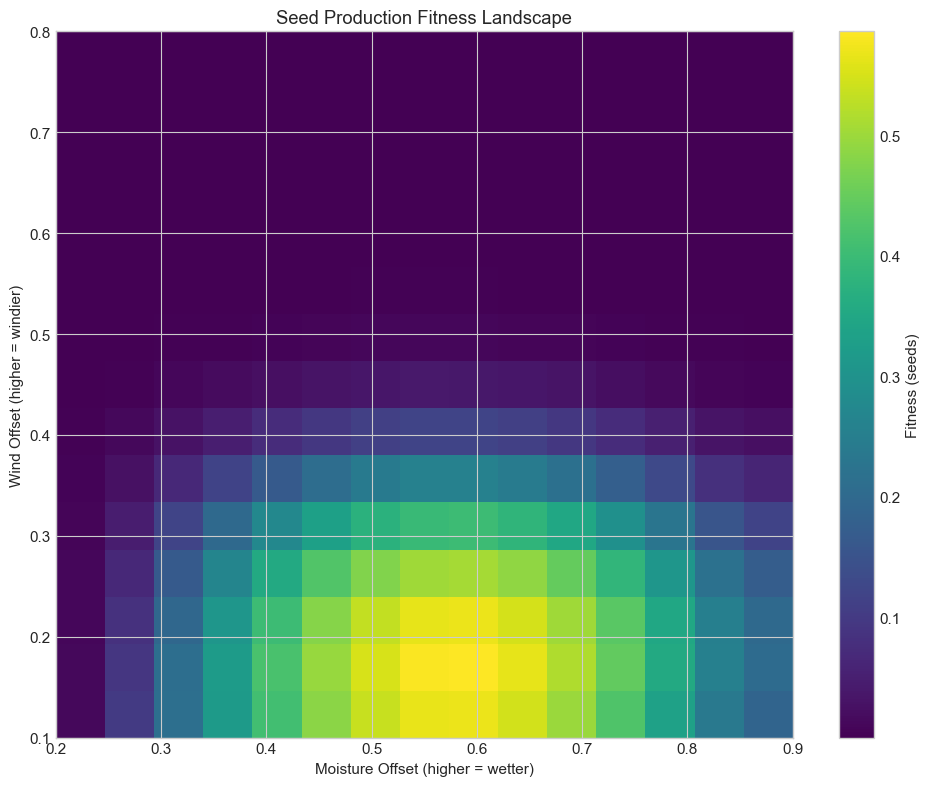

Saved: fitness_landscape.png


In [14]:
# Plot fitness landscape
fig, ax = plt.subplots(figsize=(10, 8))
plot_fitness_landscape(sweep, title='Seed Production Fitness Landscape', ax=ax)
plt.tight_layout()
plt.savefig('fitness_landscape.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fitness_landscape.png")

Running moisture sensitivity sweep...


Found 0 potential tipping points for moisture


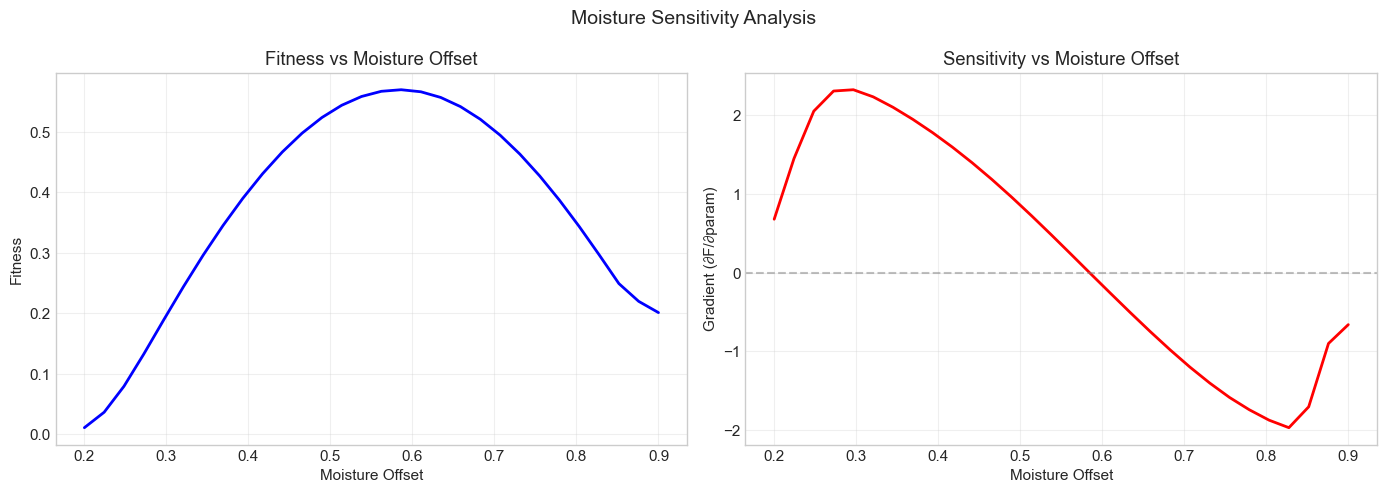

In [15]:
# Sensitivity analysis for moisture
print("Running moisture sensitivity sweep...")
moisture_sweep = sensitivity_sweep(
    seed_fitness, mild_climate, "moisture_offset", (0.2, 0.9), resolution=30
)

# Find tipping points
moisture_tips = find_tipping_points(moisture_sweep)
print(f"Found {len(moisture_tips)} potential tipping points for moisture")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_sensitivity_curve(moisture_sweep, 'Moisture Offset', axes=axes)

# Mark tipping points
for tip in moisture_tips:
    axes[0].axvline(tip['param_value'], color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(tip['param_value'], color='red', linestyle='--', alpha=0.5)

plt.suptitle('Moisture Sensitivity Analysis', fontsize=14)
plt.tight_layout()
plt.show()

Running wind sensitivity sweep...


Found 20 potential tipping points for wind


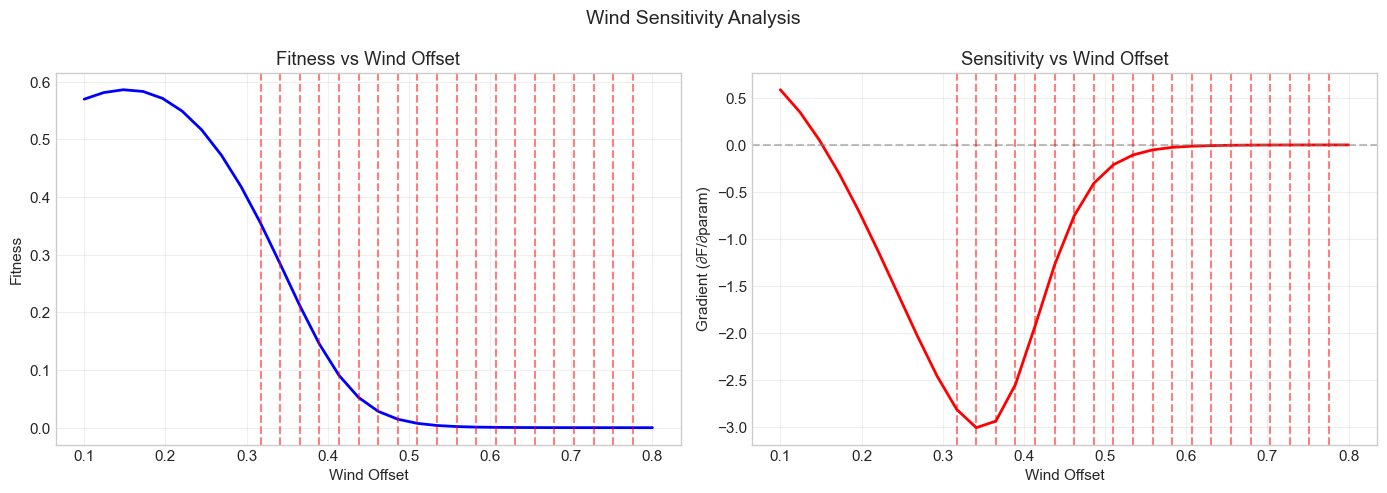

In [16]:
# Sensitivity analysis for wind
print("Running wind sensitivity sweep...")
wind_sweep = sensitivity_sweep(
    seed_fitness, mild_climate, "wind_offset", (0.1, 0.8), resolution=30
)

wind_tips = find_tipping_points(wind_sweep)
print(f"Found {len(wind_tips)} potential tipping points for wind")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_sensitivity_curve(wind_sweep, 'Wind Offset', axes=axes)

for tip in wind_tips:
    axes[0].axvline(tip['param_value'], color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(tip['param_value'], color='red', linestyle='--', alpha=0.5)

plt.suptitle('Wind Sensitivity Analysis', fontsize=14)
plt.tight_layout()
plt.show()

Computing resilience boundary...


Survival fraction: 34.2%


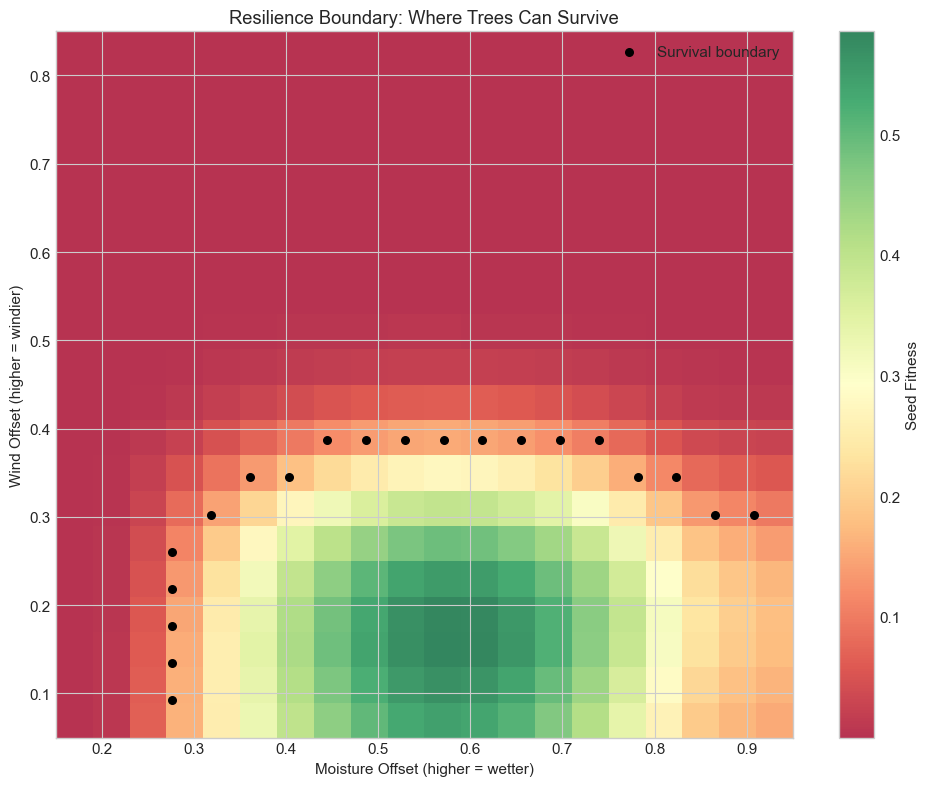

In [17]:
# Compute resilience boundary
print("Computing resilience boundary...")
boundary = compute_resilience_boundary(
    seed_fitness, mild_climate,
    survival_threshold=0.1,
    resolution=20,
)

print(f"Survival fraction: {boundary['survival_mask'].mean():.1%}")

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(
    boundary['fitness_grid'].T,
    extent=[0.15, 0.95, 0.05, 0.85],
    origin='lower',
    aspect='auto',
    cmap='RdYlGn',
    alpha=0.8,
)

# Overlay boundary
boundary_moisture, boundary_wind = boundary['boundary_points']
if len(boundary_moisture) > 0:
    ax.scatter(boundary_moisture, boundary_wind, c='black', s=30, marker='o', label='Survival boundary')

ax.set_xlabel('Moisture Offset (higher = wetter)')
ax.set_ylabel('Wind Offset (higher = windier)')
ax.set_title('Resilience Boundary: Where Trees Can Survive')
ax.legend()
plt.colorbar(im, ax=ax, label='Seed Fitness')

plt.tight_layout()
plt.show()

## 6. Summary and Climate Implications

### Key Findings

1. **Carbon vs Seed Tradeoff**: Policies optimized for carbon sequestration invest more heavily in trunk (wood), while seed-optimized policies focus on flowers late in the season.

2. **Permanence Matters**: A ton of carbon in trunk wood (permanence=1.0) has more climate value than a ton in leaves (permanence=0.1) because leaves decompose and release CO2 back to atmosphere.

3. **Tipping Points**: Tree survival drops sharply below certain moisture thresholds and above certain wind thresholds. These are the "tipping points" where ecosystems collapse.

4. **Resilience Boundaries**: There's a well-defined region in parameter space where trees can survive. Climate change pushes conditions outside this boundary.

### Climate Relevance

- **Reforestation planning**: Understanding carbon-seed tradeoffs helps design planting strategies
- **Climate adaptation**: Identifying tipping points helps predict ecosystem vulnerability
- **Policy implications**: Carbon scoring rewards long-term storage over ephemeral biomass

In [18]:
# Save trained policies
from pathlib import Path

save_dir = Path("../")
eqx.tree_serialise_leaves(save_dir / "policy_carbon.eqx", policy_carbon)
print(f"Saved carbon-optimized policy to {save_dir / 'policy_carbon.eqx'}")

Saved carbon-optimized policy to ../policy_carbon.eqx
